# Analysis of submitted runs

In [1]:
from pathlib import Path

In [3]:
import pandas as pd
import duckdb
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
%load_ext sql

Tip: You may define configurations in /pit/trec/trec-product-search-recs/pyproject.toml or /home/mde48/.jupysql/config.

Did not find user configurations in /pit/trec/trec-product-search-recs/pyproject.toml.

In [5]:
db = duckdb.connect()
%sql db

In [6]:
%%sql

DROP TABLE IF EXISTS run_metrics;
CREATE TABLE run_metrics (
    team VARCHAR NOT NULL,
    version VARCHAR,
    query VARCHAR,
    metric VARCHAR NOT NULL,
    value FLOAT,
);
INSERT INTO run_metrics
SELECT r[1], r[2], r[3], r[4], r[5]
FROM (
    SELECT regexp_split_to_array(
        regexp_split_to_table(content, '\n'),
        '\s+'
    ) AS r
    FROM read_text('runs/*.recsys-eval')
)
WHERE length(r) = 5;

Running query in 'DuckDBPyConnection'

Count
5050


In [7]:
%%sql

DROP TABLE IF EXISTS qrels;
CREATE TABLE qrels (
    query VARCHAR,
    asin VARCHAR,
    code VARCHAR
);
INSERT INTO qrels
SELECT r[1], r[3], r[4]
FROM (
    SELECT regexp_split_to_array(
        regexp_split_to_table(content, '\n'),
        '\s+'
    ) AS r
    FROM read_text('recsys.qrels')
)

Running query in 'DuckDBPyConnection'

Count
7634


In [21]:
%%sql
ATTACH 'ucsd-products.duckdb' AS ucsd (READONLY)

Running query in 'DuckDBPyConnection'

Success


In [24]:
%%sql
DROP TABLE IF EXISTS queries;
CREATE TABLE queries (
    qid VARCHAR,
    asin VARCHAR,
);
INSERT INTO queries
SELECT "Query_id", "Query ASIN"
FROM 'rec-queries.tsv';

Running query in 'DuckDBPyConnection'

Count
50


In [8]:
%%sql
SELECT code, COUNT(*) AS n_pairs, n_pairs / (SUM(n_pairs) OVER ()) AS frac_pairs
FROM qrels
GROUP BY code
ORDER BY code

Running query in 'DuckDBPyConnection'

code,n_pairs,frac_pairs
C0,212,0.027770500392978778
C1,283,0.03707099816609903
C2,144,0.018862981399004455
NR,4139,0.5421797222949961
S0,811,0.10623526329578203
S1,547,0.07165313073094053
S2,341,0.0446685878962536
UA,1156,0.15142782289756354
None,1,0.00013099292638197538


## Annotation Summary

In [9]:
annots = db.table('qrels').df()
annots['code'] = annots['code'].astype('category').cat.reorder_categories(['C0', 'C1', 'C2', 'S0', 'S1', 'S2', 'NR', 'UA'])

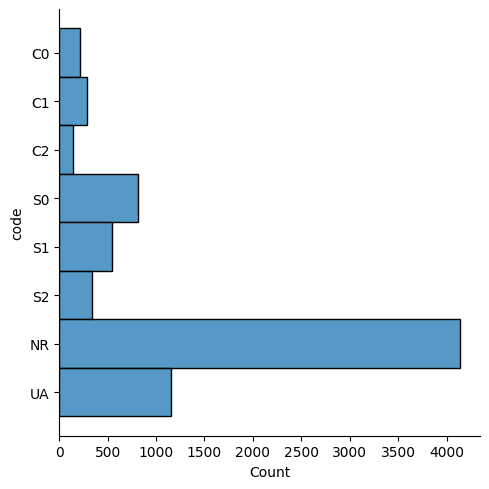

In [10]:
sns.displot(annots, y='code')
plt.show()

## Metric Summary

In [11]:
%%sql metrics <<
PIVOT (
    SELECT * FROM run_metrics
    WHERE query <> 'all'
)
ON metric
USING any_value(value)
GROUP BY team, version, query

Running query in 'DuckDBPyConnection'

In [12]:
metrics

team,version,query,P@1,P@10,P@5,PoolNDCG_10,R@1,R@10,R@5,agreement,avg_ndcg,diversity,nDCG_10,num_ret
jbnu-r01,complementary,PSRT_Recs_024C,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,1.3632999658584595,0.0,10.0
jbnu-r01,complementary,PSRT_Recs_041C,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,0.600600004196167,0.0,10.0
jbnu-r01,related,PSRT_Recs_014R,None,None,None,0.6933000087738037,None,None,None,0.8356999754905701,0.45249998569488525,None,None,None
jbnu-r01,related,PSRT_Recs_042R,None,None,None,0.6093000173568726,None,None,None,-0.13920000195503235,0.46459999680519104,None,None,None
jbnu-r02,complementary,PSRT_Recs_001C,0.0,0.20000000298023224,0.20000000298023224,None,0.0,1.0,1.0,None,None,0.8066999912261963,0.6309000253677368,5.0
jbnu-r02,complementary,PSRT_Recs_003C,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,0.4593000113964081,0.0,10.0
jbnu-r02,complementary,PSRT_Recs_004C,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,1.6888999938964844,0.0,10.0
jbnu-r02,complementary,PSRT_Recs_016C,1.0,0.30000001192092896,0.6000000238418579,None,0.05559999868273735,0.16670000553131104,0.16670000553131104,None,None,0.8963000178337097,0.30660000443458557,10.0
jbnu-r02,complementary,PSRT_Recs_018C,0.0,0.30000001192092896,0.4000000059604645,None,0.0,0.15790000557899475,0.10530000180006027,None,None,0.45329999923706055,0.2087000012397766,10.0
jbnu-r02,substitute,PSRT_Recs_038S,1.0,0.5,1.0,None,0.08330000191926956,0.41670000553131104,0.41670000553131104,None,None,0.3319000005722046,0.5809999704360962,10.0


In [13]:
%%sql
SELECT DISTINCT metric FROM run_metrics

Running query in 'DuckDBPyConnection'

metric
P@5
R@5
R@10
P@1
R@1
num_ret
P@10
nDCG_10
diversity
PoolNDCG_10


In [14]:
%%sql ndcg <<
SELECT team, CASE WHEN version = 'related' THEN 'pool' ELSE version END AS Ranking, query, value AS NDCG
FROM run_metrics
WHERE query <> 'all'
AND metric IN ('PoolNDCG_10', 'nDCG_10')

Running query in 'DuckDBPyConnection'

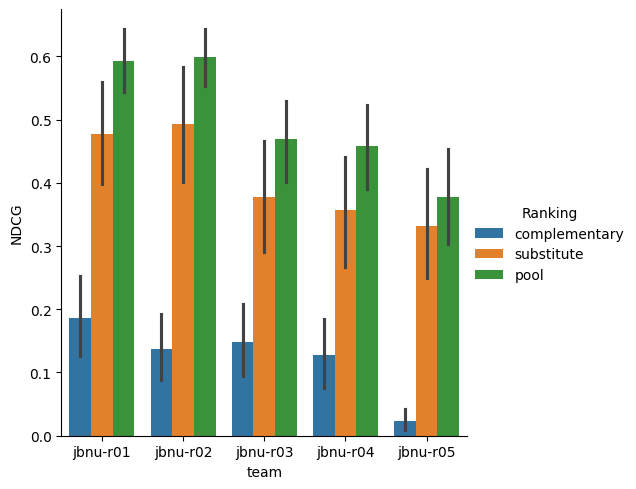

In [15]:
sns.catplot(ndcg.DataFrame(), x='team', y='NDCG', hue='Ranking', kind='bar')

In [16]:
%%sql aggr <<
SELECT team, version, query, value AS Kappa
FROM run_metrics
WHERE query <> 'all'
AND metric IN ('agreement')

Running query in 'DuckDBPyConnection'

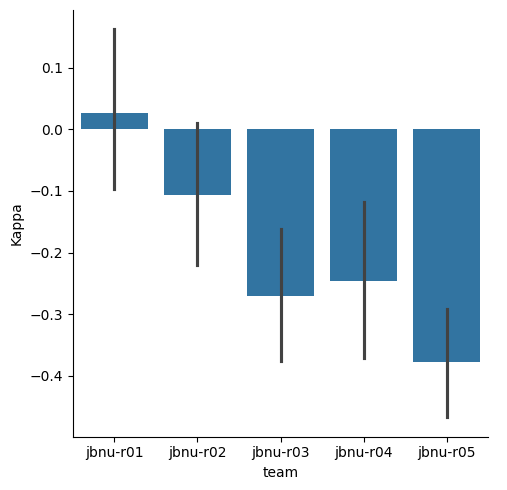

In [17]:
sns.catplot(aggr.DataFrame(), x='team', y='Kappa', kind='bar')

In [18]:
%%sql aggr <<
SELECT team, version, query, value AS ILS
FROM run_metrics
WHERE query <> 'all'
AND metric IN ('diversity')

Running query in 'DuckDBPyConnection'

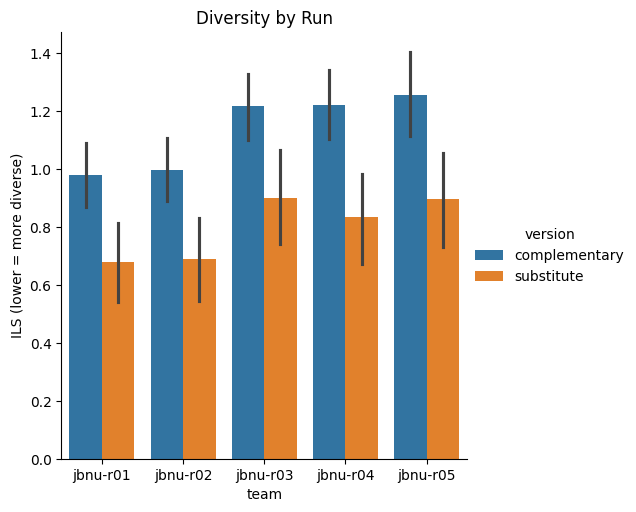

In [19]:
sns.catplot(aggr.DataFrame(), x='team', y='ILS', hue='version', kind='bar')
plt.title("Diversity by Run")
plt.ylabel("ILS (lower = more diverse)")
plt.show()

## By Category

In [35]:
%%sql ndcg <<
SELECT category, team, CASE WHEN version = 'related' THEN 'pool' ELSE version END AS Ranking, query, value AS NDCG
FROM run_metrics rm
JOIN queries q ON (rm.query[:-2] = q.qid)
JOIN ucsd.products USING (asin)
WHERE query <> 'all'
AND metric IN ('PoolNDCG_10', 'nDCG_10')

Running query in 'DuckDBPyConnection'

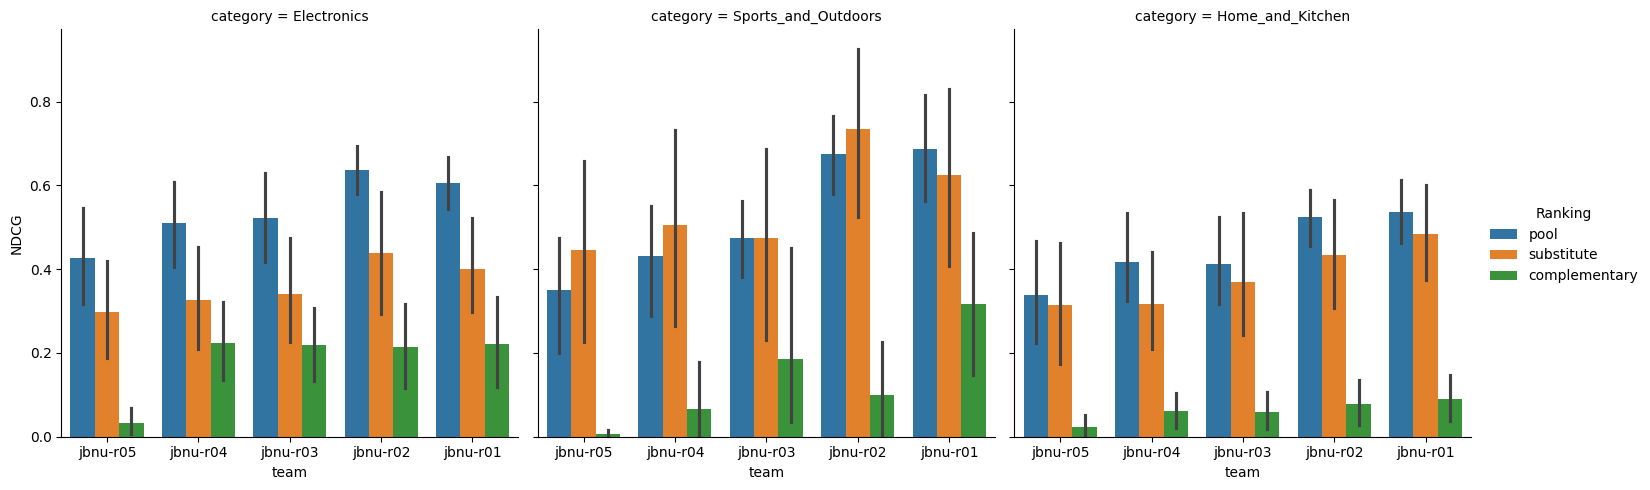

In [38]:
sns.catplot(ndcg.DataFrame(), x='team', y='NDCG', hue='Ranking', col='category', kind='bar')
plt.show()

## Assessment Crosstab